In [3]:
import numpy as np
import matplotlib.pyplot as plt


In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
df = pd.read_csv(url)

X = df[['rm', 'crim']].values
y = df['medv'].values.reshape(-1, 1)


ModuleNotFoundError: No module named 'pandas'

In [ ]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X = (X - X_mean) / X_std

In [ ]:
np.random.seed(42)
indices = np.random.permutation(len(X))
split = int(0.8 * len(X))

train_idx, test_idx = indices[:split], indices[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


In [ ]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

In [ ]:
class MLP:
    def __init__(self, lr=0.01, optimizer="gd", beta=0.9):
        self.lr = lr
        self.optimizer = optimizer
        self.beta = beta

        self.W1 = np.random.randn(2, 5)
        self.b1 = np.zeros((1, 5))

        self.W2 = np.random.randn(5, 3)
        self.b2 = np.zeros((1, 3))

        self.W3 = np.random.randn(3, 1)
        self.b3 = np.zeros((1, 1))

        self.v = {}
        self.m = {}

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = np.maximum(0, self.z1)

        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = np.maximum(0, self.z2)

        self.y_hat = self.a2 @ self.W3 + self.b3
        return self.y_hat

    def loss(self, y, y_hat):
        return np.mean((y - y_hat) ** 2)

    def backward(self, X, y, lam=0.001):
        m = X.shape[0]

        d3 = -2 * (y - self.y_hat) / m
        dW3 = self.a2.T @ d3 + 2 * lam * self.W3
        db3 = np.sum(d3, axis=0, keepdims=True)

        d2 = (d3 @ self.W3.T) * (self.z2 > 0)
        dW2 = self.a1.T @ d2 + 2 * lam * self.W2
        db2 = np.sum(d2, axis=0, keepdims=True)

        d1 = (d2 @ self.W2.T) * (self.z1 > 0)
        dW1 = X.T @ d1 + 2 * lam * self.W1
        db1 = np.sum(d1, axis=0, keepdims=True)

        return dW1, db1, dW2, db2, dW3, db3


    def update_gd(self, grads):
        dW1, db1, dW2, db2, dW3, db3 = grads

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

    def update_gd_momentum(self, grads):
        for name, grad in zip(
            ['W1','b1','W2','b2','W3','b3'],
            grads):

            if name not in self.v:
                self.v[name] = np.zeros_like(grad)

            self.v[name] = self.beta * self.v[name] + self.lr * grad
            setattr(self, name, getattr(self, name) - self.v[name])

    def update_adam(self, grads, t, beta1=0.9, beta2=0.999, eps=1e-8):
        for name, grad in zip(
            ['W1','b1','W2','b2','W3','b3'], grads):

            if name not in self.m:
                self.m[name] = np.zeros_like(grad)
                self.v[name] = np.zeros_like(grad)

            self.m[name] = beta1 * self.m[name] + (1 - beta1) * grad
            self.v[name] = beta2 * self.v[name] + (1 - beta2) * grad**2

            m_hat = self.m[name] / (1 - beta1**t)
            v_hat = self.v[name] / (1 - beta2**t)

            setattr(self, name,
                getattr(self, name) - self.lr * m_hat / (np.sqrt(v_hat) + eps)
            )


In [ ]:
def train(model, X, y, epochs=1000):
    losses = []

    for epoch in range(1, epochs + 1):
        y_hat = model.forward(X)
        loss = model.loss(y, y_hat)
        losses.append(loss)

        grads = model.backward(X, y)

        if model.optimizer == "adam":
            model.update_adam(grads, epoch)
        elif model.optimizer == "momentum":
            model.update_gd_momentum(grads)
        else:
            model.update_gd(grads)

    return losses


In [ ]:
models = {
    "GD": MLP(lr=0.01, optimizer="gd"),
    "Momentum": MLP(lr=0.01, optimizer="momentum", beta=0.9),
    "Adam": MLP(lr=0.01, optimizer="adam")
}

histories = {}

for name, model in models.items():
    histories[name] = train(model, X_train, y_train)


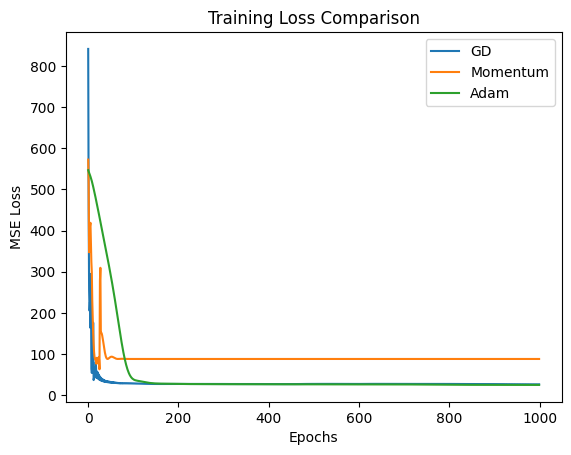

In [ ]:
for name, loss in histories.items():
    plt.plot(loss, label=name)

plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Loss Comparison")
plt.show()


In [ ]:
for name, model in models.items():
    preds = model.forward(X_test)
    mse = np.mean((y_test - preds) ** 2)
    print(f"{name} Test MSE: {mse:.4f}")



GD Test MSE: 25.5760
Momentum Test MSE: 71.2201
Adam Test MSE: 25.9220


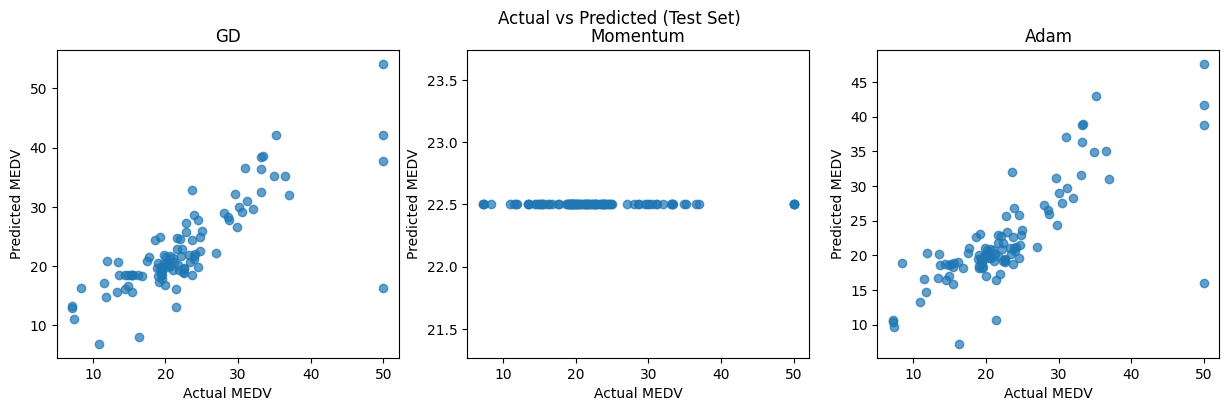

In [ ]:
plt.figure(figsize=(15,4))

for i, (name, model) in enumerate(models.items()):
    plt.subplot(1, 3, i+1)
    preds = model.forward(X_test)
    plt.scatter(y_test, preds, alpha=0.7)
    plt.xlabel("Actual MEDV")
    plt.ylabel("Predicted MEDV")
    plt.title(name)

plt.suptitle("Actual vs Predicted (Test Set)")
plt.show()


In [ ]:
# bonus 1(3 hidden layer)
class MLP_3Hidden:
    def __init__(self, lr=0.01, optimizer="gd", beta=0.9):
        self.lr = lr
        self.optimizer = optimizer
        self.beta = beta

        self.W1 = np.random.randn(2, 5) * 0.01
        self.b1 = np.zeros((1, 5))

        self.W2 = np.random.randn(5, 3) * 0.01
        self.b2 = np.zeros((1, 3))

        self.W3 = np.random.randn(3, 2) * 0.01
        self.b3 = np.zeros((1, 2))

        self.W4 = np.random.randn(2, 1) * 0.01
        self.b4 = np.zeros((1, 1))

        self.v = {}
        self.m = {}

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = np.maximum(0, self.z1)

        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = np.maximum(0, self.z2)

        self.z3 = self.a2 @ self.W3 + self.b3
        self.a3 = np.maximum(0, self.z3)

        self.y_hat = self.a3 @ self.W4 + self.b4
        return self.y_hat

    def loss(self, y, y_hat):
        return np.mean((y - y_hat) ** 2)

    def backward(self, X, y):
        m = X.shape[0]

        d4 = -2 * (y - self.y_hat) / m
        dW4 = self.a3.T @ d4
        db4 = np.sum(d4, axis=0, keepdims=True)

        d3 = (d4 @ self.W4.T) * (self.z3 > 0)
        dW3 = self.a2.T @ d3
        db3 = np.sum(d3, axis=0, keepdims=True)

        d2 = (d3 @ self.W3.T) * (self.z2 > 0)
        dW2 = self.a1.T @ d2
        db2 = np.sum(d2, axis=0, keepdims=True)

        d1 = (d2 @ self.W2.T) * (self.z1 > 0)
        dW1 = X.T @ d1
        db1 = np.sum(d1, axis=0, keepdims=True)

        return dW1, db1, dW2, db2, dW3, db3, dW4, db4

    def update_gd(self, grads):
        dW1, db1, dW2, db2, dW3, db3, dW4, db4 = grads

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4

    def update_adam(self, grads, t, beta1=0.9, beta2=0.999, eps=1e-8):
        for name, grad in zip(
            ['W1','b1','W2','b2','W3','b3','W4','b4'], grads):

            if name not in self.m:
                self.m[name] = np.zeros_like(grad)
                self.v[name] = np.zeros_like(grad)

            self.m[name] = beta1 * self.m[name] + (1 - beta1) * grad
            self.v[name] = beta2 * self.v[name] + (1 - beta2) * grad**2

            m_hat = self.m[name] / (1 - beta1**t)
            v_hat = self.v[name] / (1 - beta2**t)

            setattr(
                self,
                name,
                getattr(self, name) - self.lr * m_hat / (np.sqrt(v_hat) + eps)
            )


In [ ]:
models_bonus1 = {
    "2 Hidden (Adam)": MLP(lr=0.01, optimizer="adam"),
    "3 Hidden (Adam)": MLP_3Hidden(lr=0.01, optimizer="adam")
}

losses_bonus1 = {}

for name, model in models_bonus1.items():
    losses_bonus1[name] = train(model, X_train, y_train)


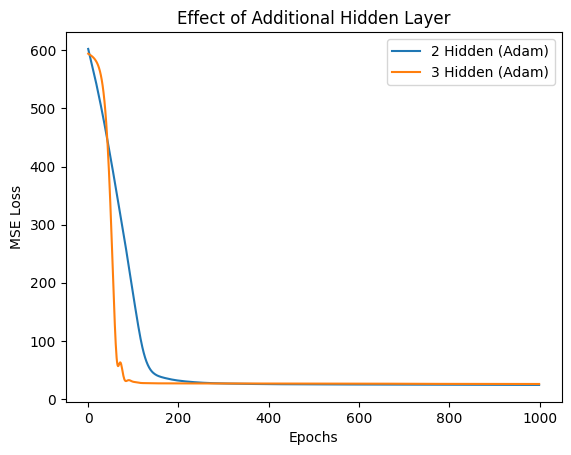

In [ ]:
for name, loss in losses_bonus1.items():
    plt.plot(loss, label=name)

plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Effect of Additional Hidden Layer")
plt.legend()
plt.show()


In [ ]:
# bonus 2(l2 regularization)
models_bonus2 = {
    "No Regularization": MLP(lr=0.01, optimizer="adam"),
    "L2 Regularization": MLP(lr=0.01, optimizer="adam")
}

losses_bonus2 = {}

for name, model in models_bonus2.items():
    losses_bonus2[name] = train(model, X_train, y_train)


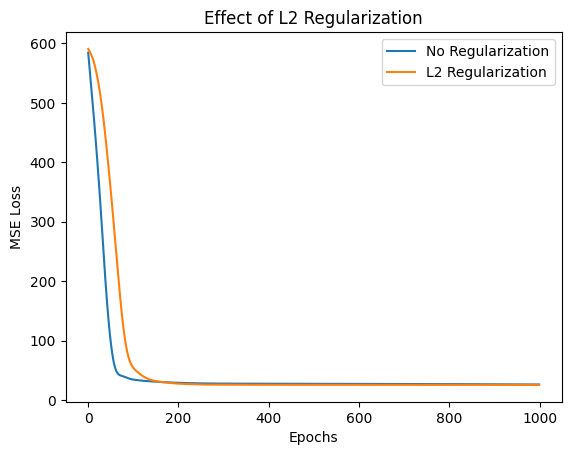

In [ ]:
for name, loss in losses_bonus2.items():
    plt.plot(loss, label=name)

plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Effect of L2 Regularization")
plt.legend()
plt.show()


In [ ]:
for name, model in models_bonus2.items():
    preds = model.forward(X_test)
    mse = np.mean((y_test - preds)**2)
    print(f"{name} Test MSE: {mse:.4f}")


No Regularization Test MSE: 26.0638
L2 Regularization Test MSE: 25.8004
